# Get experiments

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
experiments = pd.read_csv('Data/experiments.csv')
print(experiments.keys())
print()
print(experiments['Experiment'].unique())

Index(['Dimension1(nm)', 'Dimension2(nm)', 'OD', 'Dilution(%)',
       'Nano_stock_vol(mL)', 'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
       'MeOH_vol(mL)', 'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)',
       'Temperature(C)', 'Experiment'],
      dtype='object')

['1_NPL-4_(5-31-22)' '2_NPL-4_(6-1-22)' '3_NPL-11_(12-26-22)'
 '4_NPL-17_(5-3-23)' '5_NPL-17_(5-22-23)' '6_NPL-6_C.L._(7-7-23)'
 '7_NPL-12_(3-8-23)' '8_NPL-13_(3-8-23)']


# Extend the experiment df with the experiment processed results

In [3]:
import numpy as np 

def _get_peaks(x, y):
    peaks = []
    th = 0.001
    for i in range(1, len(x)-1):
        if y[i] > y[i-1]+th and y[i] > y[i+1]+th:
            peaks.append((x[i], y[i]))
    return peaks

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapz(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapz(y1, x1)/norm, np.trapz(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

In [10]:
def f_(d):
    if d.is_integer():
        return f"{int(d)}"
    else:
        decimal = len(str(d).split('.')[1])
        s = f"{d:.{decimal}f}"
        return s

processed_df = pd.DataFrame()
for exp in experiments['Experiment'].unique():
    exp_df = experiments[experiments['Experiment'] == exp]

    for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
        T, d, t = setup
        with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
            lines = input.readlines()
            x = []
            y = []
            for line in lines:
                x.append(float(line.split()[0]))
                y.append(float(line.split()[1]))
            norm_y = [yi/max(y) for yi in y]
            norm_area = get_area_under_peaks(x, y)
            peaks, areas = process_spectrum(x, y, norm_area=1)
            results_df = pd.DataFrame({'Temperature(C)': [T], 
                                        'Doping(%)': [d], 
                                        'Time(min)': [t], 
                                        'Peak1': [peaks[0]], 
                                        'Peak2': [peaks[1]], 
                                        'Area1': [areas[0]], 
                                        'Area2': [areas[1]],
                                        'Distance_peaks': [peaks[1]-peaks[0]],
                                        'ratioP2P1': [areas[1]/areas[0]],
                                        'Wavelengths': [x],
                                        'Fluorescence': [y],
                                        'Fluorescence_norm': [norm_y],}) # we can add other labels here
            new_entry = exp_df.merge(results_df, how='inner', on=['Temperature(C)', 'Doping(%)', 'Time(min)'])
        processed_df = pd.concat([processed_df, new_entry], ignore_index=True)
processed_df.to_csv('Data/processed_data.csv', index=False)

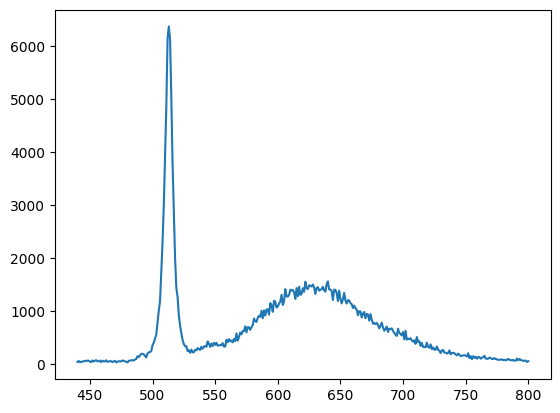

In [12]:
asd = pd.read_csv('Data/processed_data.csv')
sample = asd.iloc[0]
w = [float(a) for a in sample['Wavelengths'][1:-1].split(',')]
i = [float(a) for a in sample['Fluorescence'][1:-1].split(',')]

plt.plot(w, i, color="C0")

# Entire espectra

In [6]:
original_columns = ['Dimension1(nm)',
                    'Dimension2(nm)',
                    'OD',
                    'Dilution(%)',
                    'Nano_stock_vol(mL)',
                    'Diluted_vol(mL)',
                    'AgConc(M)',
                    'AgMass(mg)',
                    'MeOH_vol(mL)',
                    'H2O_vol(mL)',
                    'Doping(%)',
                    'AgSol(uL)',
                    'Time(min)',
                    'Temperature(C)',
                    'Experiment'
                ]

new_columns = ['Wavelength(nm)', 'Fluorescence', 'Fluorescence_norm']

with open('Data/spectra_data.csv', 'w') as output:
    output.write(','.join(original_columns + new_columns) + '\n')
    for exp in experiments['Experiment'].unique():
        exp_df = experiments[experiments['Experiment'] == exp]

        for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
            T, d, t = setup
            props = exp_df[(exp_df['Doping(%)'] == d) & (exp_df['Time(min)'] == t) & (exp_df['Temperature(C)'] == T)].iloc[0].to_list()
            with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
                lines = input.readlines()
                x = []
                y = []
                for line in lines:
                    x.append(float(line.split()[0]))
                    y.append(float(line.split()[1]))
                norm_y = [yi/max(y) for yi in y]
                for xi, yi, norm_yi in zip(x, y, norm_y):
                    new_line = props + [xi, yi, norm_yi]
                    output.write(','.join([str(p) for p in new_line]) + '\n')


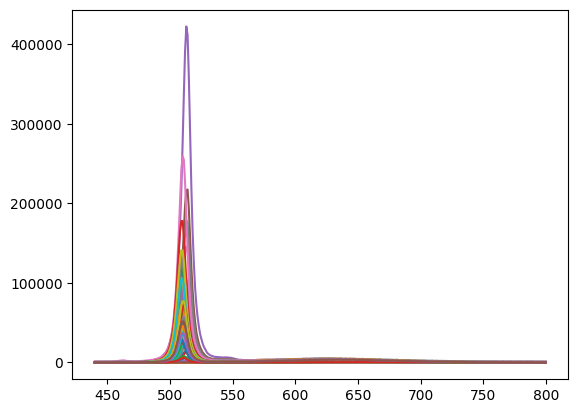

In [15]:
asd = pd.read_csv('Data/spectra_data.csv')

for group, df in asd.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    plt.plot(df['Wavelength(nm)'], df['Fluorescence'], label=group[0])
    # plt.legend()
    # break


# Creating bolift pool

In [8]:
experiments.head()

,Dimension1(nm),Dimension2(nm),OD,Dilution(%),Nano_stock_vol(mL),Diluted_vol(mL),AgConc(M),AgMass(mg),MeOH_vol(mL),H2O_vol(mL),Doping(%),AgSol(uL),Time(min),Temperature(C),Experiment
0,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,1.00,1.4,60,25,1_NPL-4_(5-31-22)
1,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,2.50,3.4,60,25,1_NPL-4_(5-31-22)
2,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,5.00,6.8,60,25,1_NPL-4_(5-31-22)
3,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,10.00,13.7,60,25,1_NPL-4_(5-31-22)
4,18.8,14.04,100x,0.175,0.25,1.75,0.0007,3.5,20,8,0.25,3.0,60,25,2_NPL-4_(6-1-22)


In [9]:
import itertools
import bolift
import cloudpickle
from dotenv import load_dotenv
load_dotenv()

prompt_template = "Stock nanoplatelets have dimensions {Dimension1(nm)} nm by {Dimension2(nm)} nm and the optical density of 100x hexanes dilution of stock is {Dilution(%)}% " \
                    "recorded at 512nm. {Nano_stock_vol(mL)} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. " \
                    "Silver acetate solution of {AgConc(M)} M is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL)} mL of MeOH and {H2O_vol(mL)} mL of water. " \
                    "{Doping(%)} % Ag doping requires {AgSol(uL)} uL of silver doping solution, respectively. " \
                    "The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. " \
                    "Fluorescence of each doped sample was collected as a 30x dilution with hexanes."

def get_partial_pool(experiments, feats):
    dict_df = experiments.groupby(by=feats).size().reset_index()[feats].to_dict()
    return [{k:v[i] for (k,v) in zip(dict_df.keys(), dict_df.values())} for i in range(len(list(dict_df.values())[0]))]

def explode_dict(dict):
    return [{k:v[i] for (k,v) in zip(dict.keys(), dict.values())} for i in range(len(list(dict.values())[0]))]

features = experiments.keys()[:-1]
feats_1=features[0:2]
feats_2=features[2:6]
feats_3=features[6:12]
feats_4=features[12:14]

pool_p1 = get_partial_pool(experiments, feats_1.to_list())
pool_p2 = get_partial_pool(experiments, feats_2.to_list())
pool_p3 = get_partial_pool(experiments, feats_3.to_list())
pool_p4 = {
    "Time(min)": [10, 60, 180],
    "Temperature(C)": [0, 25, 50],
}
pool_p4 = [{"Time(min)": v1, "Temperature(C)": v2} for (v1,v2) in itertools.product(*pool_p4.values())]


iter = itertools.product(pool_p1, pool_p2, pool_p3, pool_p4)

pool_list = []
for props in iter:
    d = {}
    for prop in props:
        d.update(prop)
    pool_list.append(prompt_template.format(**d))

with open('Data/pool.txt', 'w') as output:
    output.write('\n'.join(pool_list))

pool = bolift.Pool(pool_list)
cloudpickle.dump(pool, open('Data/pool.pkl', 'wb'))

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
